In [3]:
import os
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:58591'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:58591'

In [4]:
from osgeo import gdal,ogr
import matplotlib.pyplot as plt
import pylandstats as pls
import seaborn as sns

import glob
import re
import os
from multiprocessing import Pool

import numpy as np
import pandas as pd

import ee
ee.Initialize()

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Define parameters

In [5]:
# define the year of the true image
base_year = '2005_2007'
target_year = '2017_2019'

# define the img_type
img_type = ['mix_no_years'] #'mix_years','no_distance','with_distance',

# define the pixel value that corespondind to the year
true_image_year_val = {f'{year}_{year+2}':(i+1) for (i,year) in enumerate(range(2017,1989,-3))}

### Reprejecte the tif to WGS84 UTM 50N

In [6]:
img_proj = glob.glob(f'../Data/UNET_result_image/unet_img_each_city/no_distance_*_{base_year}_{target_year}_masked.tif')
img_true = glob.glob(f'../Data/UNET_result_image/unet_img_each_city/True_img_*_{target_year}_masked.tif')

img_to_project = img_proj +  img_true

In [129]:
for tif in  img_to_project:
    
    # read tif
    tif_ds = gdal.Open(tif)
    
    # get name
    reg = re.compile(r'\\(.*).*.tif')
    name = reg.findall(tif)[0] 

    
    # reproject
    dstTif = gdal.Warp(f'../Data/UNET_result_image/Reproject_imgs/{name}.tif',tif_ds,dstSRS = 'EPSG:32650') # WGS84 UTM 50N
    
    # report process
    print(f"Reproject {name} to WGS84 UTM 50N successful!")

Reproject no_distance_an_qing_shi_2005_2007_2017_2019_masked to WGS84 UTM 50N successful!
Reproject no_distance_an_yang_shi_2005_2007_2017_2019_masked to WGS84 UTM 50N successful!
Reproject no_distance_bang_bu_shi_2005_2007_2017_2019_masked to WGS84 UTM 50N successful!
Reproject no_distance_bao_ding_shi_2005_2007_2017_2019_masked to WGS84 UTM 50N successful!
Reproject no_distance_bei_jing_shi_2005_2007_2017_2019_masked to WGS84 UTM 50N successful!
Reproject no_distance_bin_zhou_shi_2005_2007_2017_2019_masked to WGS84 UTM 50N successful!
Reproject no_distance_bo_zhou_shi_2005_2007_2017_2019_masked to WGS84 UTM 50N successful!
Reproject no_distance_cang_zhou_shi_2005_2007_2017_2019_masked to WGS84 UTM 50N successful!
Reproject no_distance_chang_zhou_shi_2005_2007_2017_2019_masked to WGS84 UTM 50N successful!
Reproject no_distance_cheng_de_shi_2005_2007_2017_2019_masked to WGS84 UTM 50N successful!
Reproject no_distance_chi_zhou_shi_2005_2007_2017_2019_masked to WGS84 UTM 50N successful!


Reproject True_img_huai_an_shi_2017_2019 to WGS84 UTM 50N successful!
Reproject True_img_huai_bei_shi_2017_2019 to WGS84 UTM 50N successful!
Reproject True_img_huai_nan_shi_2017_2019 to WGS84 UTM 50N successful!
Reproject True_img_huang_shan_shi_2017_2019 to WGS84 UTM 50N successful!
Reproject True_img_jiao_zuo_shi_2017_2019 to WGS84 UTM 50N successful!
Reproject True_img_ji_nan_shi_2017_2019 to WGS84 UTM 50N successful!
Reproject True_img_ji_ning_shi_2017_2019 to WGS84 UTM 50N successful!
Reproject True_img_kai_feng_shi_2017_2019 to WGS84 UTM 50N successful!
Reproject True_img_lai_wu_shi_2017_2019 to WGS84 UTM 50N successful!
Reproject True_img_lang_fang_shi_2017_2019 to WGS84 UTM 50N successful!
Reproject True_img_lian_yun_gang_shi_2017_2019 to WGS84 UTM 50N successful!
Reproject True_img_liao_cheng_shi_2017_2019 to WGS84 UTM 50N successful!
Reproject True_img_lin_yi_shi_2017_2019 to WGS84 UTM 50N successful!
Reproject True_img_liu_an_shi_2017_2019 to WGS84 UTM 50N successful!
Reproj

### Compute the Landscapte Metrics

In [7]:
# get the projected tif imgs
img_city_true = glob.glob(f'../Data/UNET_result_image/Reproject_imgs/True_img_*{target_year}_masked.tif')
img_city_prj = glob.glob(f'../Data/UNET_result_image/Reproject_imgs/no_distance_*_{base_year}_{target_year}_masked.tif')
img_city_UTM = {'True':img_city_true,
                'Proj':img_city_prj}

In [8]:
multprocess_args = []

# compute landscapte metrics
for img_type,tifs in img_city_UTM.items():
    for tif in tifs:
    
        # get name
        reg = re.compile(r'\\((True_img_)|(no_distance_))(.*?)_\d{4}_\d{4}.*tif')
        name = reg.findall(tif)[0][3]
        
        # append args to list
        multprocess_args.append((name,img_type,tif))

In [ ]:
from  multiprocessing_func  import compute_ls_metrics

if __name__ == '__main__':
    with Pool(5) as p:
        lanscape_metrics_list = p.starmap(compute_ls_metrics, multprocess_args)

In [ ]:
# save result to disk
lanscape_metrics = pd.concat(lanscape_metrics_list)
lanscape_metrics = pd.DataFrame(lanscape_metrics.set_index(['City','Img_type']).stack())
lanscape_metrics = lanscape_metrics.reset_index()
lanscape_metrics = lanscape_metrics.pivot(index='City',columns=['Img_type','level_2'],values=0)
lanscape_metrics.columns = ['_'.join(col) for col in lanscape_metrics.columns]
lanscape_metrics.index.name = None

lanscape_metrics.to_csv(f'../Data/Result_csv/lanscape_metrics_{base_year}_{target_year}.csv')

In [ ]:
lanscape_metrics

<AxesSubplot:xlabel='True_number_of_patches', ylabel='Proj_number_of_patches'>

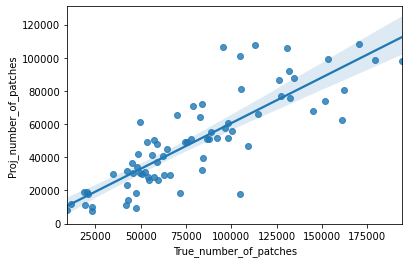

In [10]:
sns.regplot(data=lanscape_metrics,x='True_number_of_patches',y='Proj_number_of_patches')

<AxesSubplot:xlabel='True_area_mn', ylabel='Proj_area_mn'>

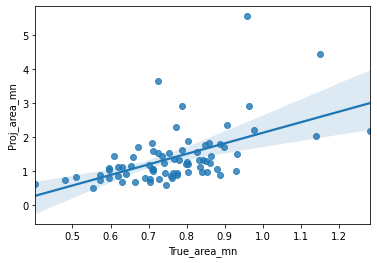

In [15]:
sns.regplot(data=lanscape_metrics,x='True_area_mn',y='Proj_area_mn')

<AxesSubplot:xlabel='True_patch_density', ylabel='Proj_patch_density'>

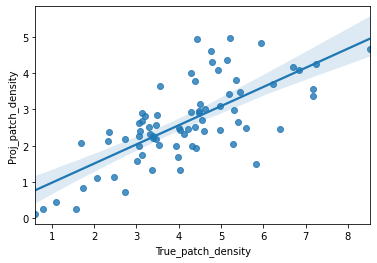

In [11]:
sns.regplot(data=lanscape_metrics,x='True_patch_density',y='Proj_patch_density')

<AxesSubplot:xlabel='True_landscape_shape_index', ylabel='Proj_landscape_shape_index'>

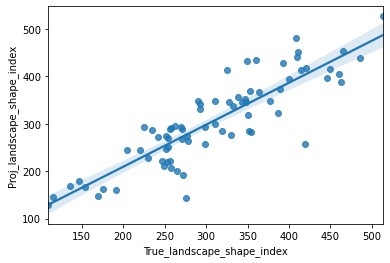

In [12]:
sns.regplot(data=lanscape_metrics,
            x='True_landscape_shape_index',
            y='Proj_landscape_shape_index')

<AxesSubplot:xlabel='True_effective_mesh_size', ylabel='Proj_effective_mesh_size'>

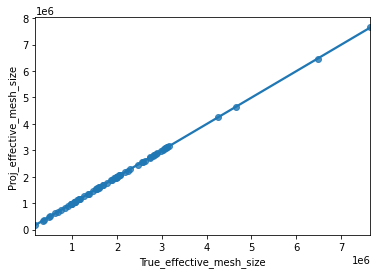

In [13]:
sns.regplot(data=lanscape_metrics,x='True_effective_mesh_size',y='Proj_effective_mesh_size')

<AxesSubplot:xlabel='True_largest_patch_index', ylabel='Proj_largest_patch_index'>

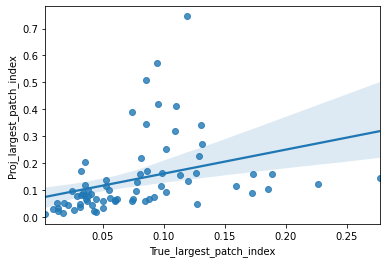

In [14]:
sns.regplot(data=lanscape_metrics[lanscape_metrics['True_largest_patch_index'] < 0.5],
            x='True_largest_patch_index',
            y='Proj_largest_patch_index')